# Inports

In [2]:
import numpy as np
from numpy.random import seed
import pandas as pd

from absl import app
from absl import flags
import os 
from os.path import join
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from utils import *
# from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions



In [32]:



class Exp : 

    def __init__(self, exp_path) :
        self.exp_path = exp_path
        self.corrupt = self.check_corrupt()
        if not self.corrupt :
            self.args = load_json_field(join(exp_path, 'args.json'))
            self.load_history()
    
    def check_corrupt(self) :
        if not os.path.exists(join(self.exp_path, 'args.json')) : 
            return True 
        files = os.listdir(self.exp_path)
        for file in files : 
            if file.endswith('.csv') or file.endswith('.npy') :
                return False
        return True

    def load_history(self) :
        if self.args['learning_algorithm'] == 'central' : 
            if not os.path.exists(join(self.exp_path, 'centralized.csv')) :
                self.corrupt = True 
                return
            history = pd.read_csv(join(self.exp_path, 'centralized.csv'))
            self.acc = history['val_accuracy']
            self.loss = history['val_loss']
        elif self.args['learning_algorithm'] == 'local' :
            if not os.path.exists(join(self.exp_path, 'client_0.csv')) :
                self.corrupt = True 
                return
            client_files = [f for f in os.listdir(self.exp_path) if (f.startswith('client') and f.endswith('.csv'))]
            histories = [pd.read_csv(join(self.exp_path, f)) for f in client_files]
            self.accs = [h['val_accuracy'] for h in histories]
            self.losses = [h['val_loss'] for h in histories]
            self.acc = np.mean(self.accs, axis=0)
            self.loss = np.mean(self.losses, axis=0)

        elif self.args['learning_algorithm'].startswith('fed') : 
            if not os.path.exists(join(self.exp_path, 'accuracy.npy')) :
                self.corrupt = True 
                return
            
            self.acc = np.load(join(self.exp_path, 'accuracy.npy'))
            self.loss = np.load(join(self.exp_path, 'loss.npy'))

    
    def plot(self, metric='acc', labels=None) :
        
        if labels is not None : 
            mylabels = '_'.join([str(self.args[k]) for k in labels])
        else :
            mylabels = ''
        
        if metric == 'acc' : 
            plt.plot(self.acc, label=mylabels)
        elif metric == 'loss' : 
            plt.plot(self.loss, label=mylabels)
        else : 
            raise ValueError('Invalid metric')

        plt.legend()




class ExpSet : 

    def __init__(self, exps) :
        self.exps = exps
    
    def plot(self, metric='acc', labels=None, filter = None) :
        exps = self.exps
        if filter is not None :
            for k, v in filter.items() : 
                exps = [exp for exp in exps if exp.args[k] == v]
            
        mylabels = ['' ] * len(exps)
        if labels is not None : 
            for i, exp in enumerate(exps) : 
                mylabels[i] = '_'.join([str(exp.args[k]) for k in labels])
        
        ys = []
        for exp in exps :
            if metric == 'acc' : 
                ys.append(exp.acc)
            elif metric == 'loss' : 
                ys.append(exp.loss)
            else : 
                raise ValueError('Invalid metric')
        
        for i, y in enumerate(ys) :
            plt.plot(y, label=mylabels[i])

        plt.legend(prop={'size': 13}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.2)
        


# Central performance

In [ ]:
experiment_id = 'algorithm' + '_' + 'central' + '_'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]
print(experiment_paths)
for exp_path in experiment_paths :
    
    history = pd.read_csv(join(exp_path, 'centralized.csv'))
    central_acc = history['val_accuracy']


    plt.plot(central_acc)

# Local performance

In [ ]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'local' \
        and exp.args['lr'] == 0.001 and exp.args['use_dp'] == True:
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)


# Federated Learning performance

## FedAvg

In [ ]:

experiment_id = 'fedavg'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]



for p in experiment_paths :
    things = p.split('/')[-1].split('_')
    
    if not os.path.exists(join(p, 'accuracy.npy')): 
        continue 
    
    use_dp =  load_json_field(join(p, 'args.json'), 'use_dp')
    eps = load_json_field(join(p, 'args.json'), 'dp_epsilon')
    alg = load_json_field(join(p, 'args.json'), 'learning_algorithm')
    acc = np.load(join(p, 'accuracy.npy'))
    plt.plot(acc, label=alg + '_' + str(use_dp) + '_' + str(eps))

plt.legend()
plt.show()


## Fedsgd

In [ ]:

experiment_id = 'cifar10' + '_' + 'fedsgd' + '_'
experiment_path = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name][0]
print("experiment path:", experiment_path)

fedsgd_acc = np.load(join(experiment_path, 'accuracy.npy'))
# plot accuracy
plt.plot(fedsgd_acc)

In [ ]:

experiment_id = 'cifar10' + '_' + 'fedakd' + '_'
experiment_path = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name][0]
print("experiment path:", experiment_path)

fedsgd_acc = np.load(join(experiment_path, 'accuracy.npy'))
# plot accuracy
plt.plot(fedsgd_acc)

## Compare performance

adv_cmp
[0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0]
rdp
[0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0]
dp
[0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0]


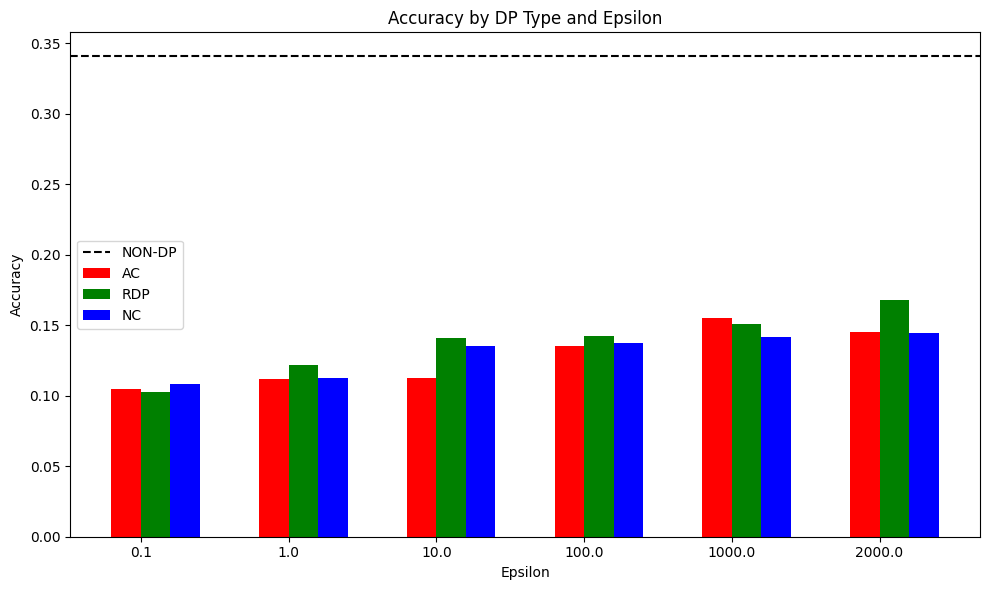

In [64]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

local_dp, local_nondp = [], []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'local' and exp.args['lr'] == 0.01 :
        if exp.args['use_dp'] : 
            local_dp.append(exp)
        else :
            local_nondp.append(exp)

dp_types_exps = dict() 
for exp in local_dp :
    if exp.args['dp_type'] not in dp_types_exps : 
        dp_types_exps[exp.args['dp_type']] = []
    dp_types_exps[exp.args['dp_type']].append(exp)
for k, v in dp_types_exps.items() :
    # sort by epsilon
    v.sort(key=lambda x: x.args['dp_epsilon'])
    print(k) 
    print([e.args['dp_epsilon'] for e in v]) 



epsilon_values = sorted(list(set(exp.args['dp_epsilon'] for exp_list in dp_types_exps.values() for exp in exp_list)))
group_labels = list(dp_types_exps.keys())
dp_types_to_labels = {'rdp': 'RDP', 'adv_cmp':'AC', 'dp': 'NC'}
num_epsilon_values = len(epsilon_values)
num_groups = len(dp_types_exps)

bar_width = 0.2
index = np.arange(num_epsilon_values)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['r', 'g', 'b']

for i, dp_type in enumerate(group_labels):
    exp_list = dp_types_exps[dp_type]
    acc_values = [exp.acc[-1] for exp in exp_list]

    bar_positions = index + (i - num_groups // 2 + 0.5) * bar_width
    ax.bar(bar_positions, acc_values, width=bar_width, align='center', label=dp_types_to_labels[dp_type], color=colors[i])

# draw horizontal lines
ax.axhline(y=np.mean([e.acc[-1] for e in local_nondp]), color='k', linestyle='--', label='NON-DP')

ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by DP Type and Epsilon')
ax.set_xticks(index)
ax.set_xticklabels(epsilon_values)
ax.legend()

plt.tight_layout()
plt.show()


# DP relaxations noise vs epsilon

### 1

In [ ]:
n = 60_000 
bs = 200
e = 20 
delta = 1e-5
dp_types = ['dp', 'adv_cmp', 'rdp'] 

epsilons_range = np.arange(1, 1000, 5)

noise_multipliers = np.zeros((len(dp_types), len(epsilons_range)))
for dp_i, dp_type in enumerate(dp_types) : 
    for eps_i, eps in enumerate(epsilons_range) : 
        ac = DPAccountant(
            data_size= n,
            batch_size= bs, 
            epochs = e,
            target_delta = delta, 
            dp_type = dp_type
        )
        sigma = ac.get_noise_multiplier(target_epsilon=eps)
        noise_multipliers[dp_i, eps_i] = sigma

for dp_i, dp_type in enumerate(dp_types) : 
    plt.plot(epsilons_range[:20], noise_multipliers[dp_i, :20], label=dp_type)
plt.legend()


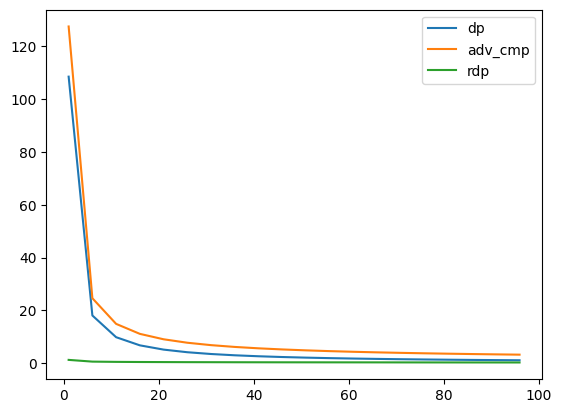

### 2

NC
(0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0)
(48.44805262605389, 4.844805262605389, 0.4844805262605389, 0.04844805262605389, 0.004844805262605389, 0.0024224026313026943)

AC
(0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0)
(247.34778138229277, 25.605116690792524, 3.232454373215927, 0.6367427254900667, 0.17046309798703502, 0.11781493603567814)

RDP
(0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0)
(9.21875, 1.650390625, 0.5712890625, 0.2020263671875, 0.09246826171875, 0.067901611328125)



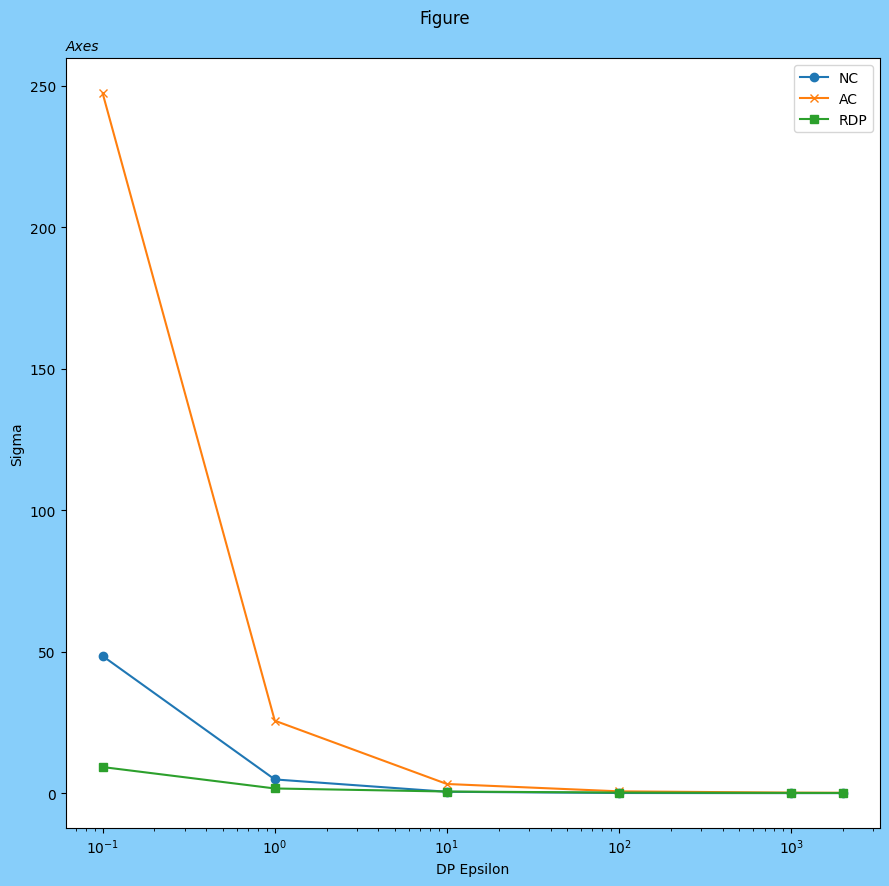

In [51]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

fav_exps = []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['dataset'] == 'cifar10' and exp.args['learning_algorithm'] == 'local' and exp.args['lr'] == 0.001 and exp.args['use_dp'] == True :
        fav_exps.append(exp)

dp_types = ["dp", "adv_cmp", "rdp"]
labels = ['NC', 'AC', 'RDP']
markers = ['o', 'x', 's']

fig, ax = plt.subplots(figsize=(9, 9), facecolor='lightskyblue')
fig.suptitle('Figure')

ax.set_title('Axes', loc='left', fontstyle='oblique', fontsize='medium')

for i, dp_type in enumerate(dp_types):
    expss = [exp for exp in fav_exps if exp.args['dp_type'] == dp_type]
    xs, ys = [exp.args['dp_epsilon'] for exp in expss], [exp.args['sigma'] for exp in expss]
    xs, ys = zip(*sorted(zip(xs, ys), key=lambda x: x[0]))

    ax.plot(xs, ys, marker=markers[i], label=labels[i])

ax.set_xlabel('DP Epsilon')
ax.set_ylabel('Sigma')

ax.legend()

# Set the x-axis tick labels to the values in xs
ax.set_xticks(xs)

# Set the x-axis to log scale
ax.set_xscale('log')

plt.tight_layout()
plt.show()

## MIA results

In [ ]:
id = 12
exp_id = 'exp_{}'.format(id)
EXP_PATH = join(DATA_PATH, exp_id)
attack_results_file = join(EXP_PATH, 'attack_results', 'attack_results.npy')
attack_results = np.load(attack_results_file, allow_pickle= True).item()  

fpr, tpr, thresholds = attack_results['fpr'], attack_results['tpr'], attack_results['thresholds']
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("fpr:", fpr)
print("tpr:", tpr)
print("thresholds:", thresholds)